In [8]:
import fastf1
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
from fastf1 import plotting
import matplotlib.pyplot as plt
from fastf1.utils import delta_time
from scipy.ndimage import label
from scipy.version import git_revision

#fastf1.Cache.enable_cache('cache')

session =  fastf1.get_session(2025, "Azerbaijan Grand Prix", "Q")
session.load()

print(session.event)
print(session.results)



core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            IN

RoundNumber                                                         17
Country                                                     Azerbaijan
Location                                                          Baku
OfficialEventName    FORMULA 1 QATAR AIRWAYS AZERBAIJAN GRAND PRIX ...
EventDate                                          2025-09-21 00:00:00
EventName                                        Azerbaijan Grand Prix
EventFormat                                               conventional
Session1                                                    Practice 1
Session1Date                                 2025-09-19 12:30:00+04:00
Session1DateUtc                                    2025-09-19 08:30:00
Session2                                                    Practice 2
Session2Date                                 2025-09-19 16:00:00+04:00
Session2DateUtc                                    2025-09-19 12:00:00
Session3                                                    Practice 3
Sessio

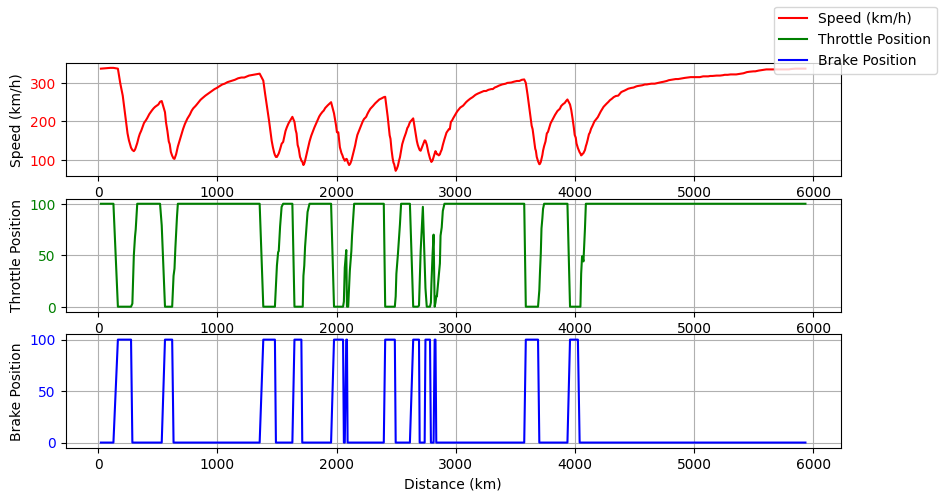

In [59]:
v_laps = session.laps.pick_drivers("VER")
v_fastest_lap = laps.pick_fastest()
v_telemetry = fastest_lap.get_car_data().add_distance()


fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(10,5))

ax1.plot(v_telemetry['Distance'], v_telemetry['Speed'], color='red', label='Speed (km/h)')
ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Speed (km/h)')
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(True)


ax2.plot(v_telemetry['Distance'], v_telemetry['Throttle'], color='green', label='Throttle Position')
ax2.set_ylabel('Throttle Position')
ax2.set_xlabel('Distance (km)')
ax2.tick_params(axis='y', labelcolor='green')
ax2.grid(True)


ax3.plot(v_telemetry['Distance'], v_telemetry['Brake']*100, color='blue', label='Brake Position')
ax3.set_ylabel('Brake Position')
ax3.set_xlabel('Distance (km)')
ax3.tick_params(axis='y', labelcolor='blue')
ax3.grid(True)


fig.legend(loc='upper right')
plt.grid(True)
plt.show()




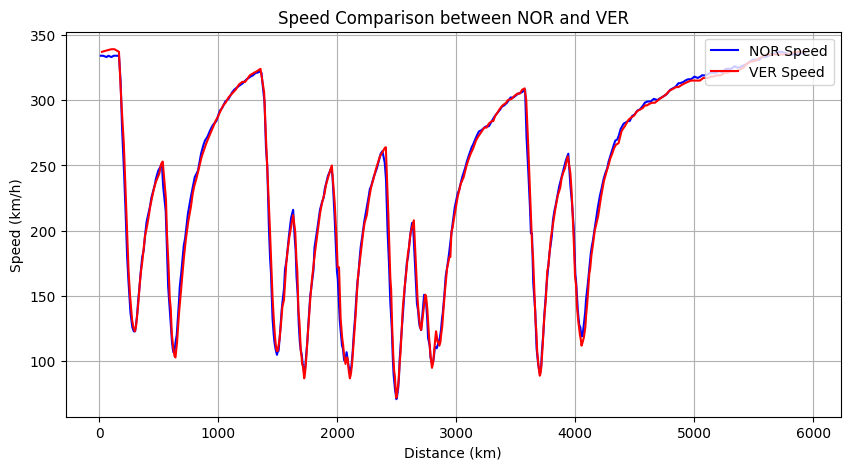

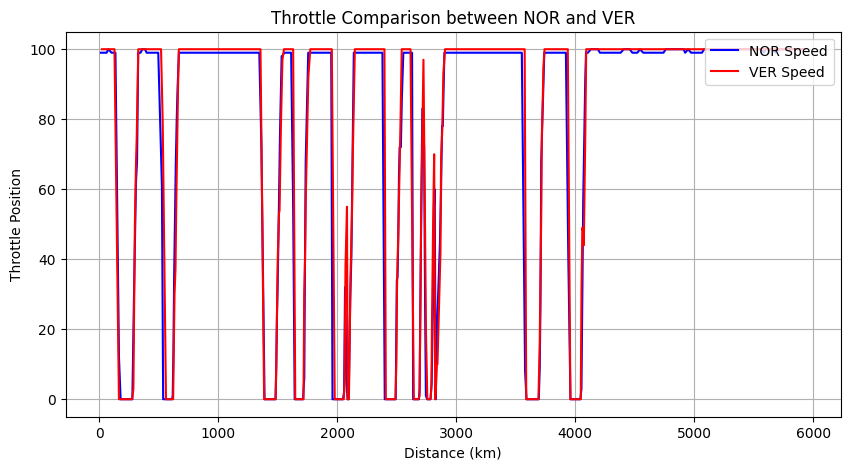

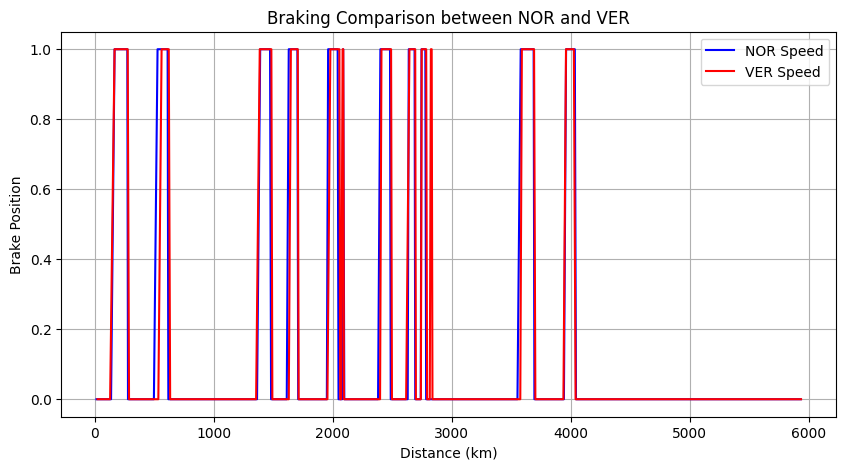

In [62]:
#Two driver comparision

n_laps = session.laps.pick_drivers("NOR").pick_fastest()

n_telemetry = n_laps.get_car_data().add_distance()

plt.figure(figsize=(10,5))
plt.plot(n_telemetry['Distance'], n_telemetry['Speed'], color='blue', label='NOR Speed')
plt.plot(v_telemetry['Distance'], v_telemetry['Speed'], color='red', label='VER Speed')
plt.xlabel('Distance (km)')
plt.ylabel('Speed (km/h)')
plt.title('Speed Comparison between NOR and VER')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(n_telemetry['Distance'], n_telemetry['Throttle'], color='blue', label='NOR Speed')
plt.plot(v_telemetry['Distance'], v_telemetry['Throttle'], color='red', label='VER Speed')
plt.xlabel('Distance (km)')
plt.ylabel('Throttle Position')
plt.title('Throttle Comparison between NOR and VER')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(n_telemetry['Distance'], n_telemetry['Brake'], color='blue', label='NOR Speed')
plt.plot(v_telemetry['Distance'], v_telemetry['Brake'], color='red', label='VER Speed')
plt.xlabel('Distance (km)')
plt.ylabel('Brake Position')
plt.title('Braking Comparison between NOR and VER')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


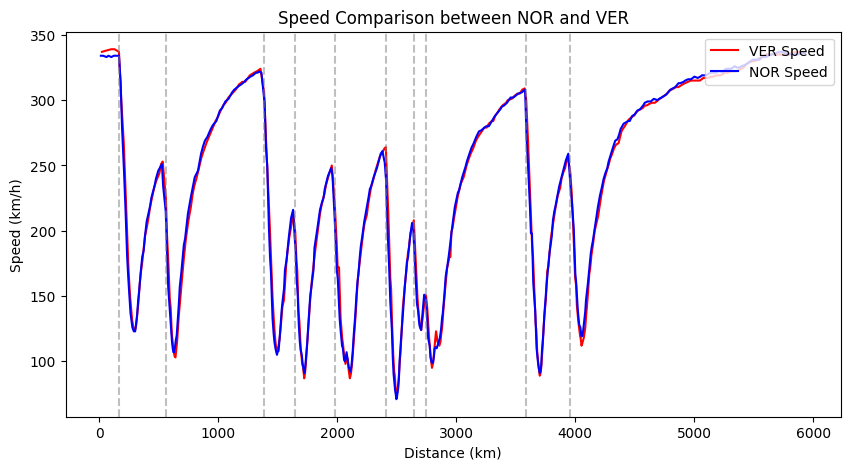

In [69]:
#Highlighting Braking Zones

braking_points = v_telemetry[v_telemetry['Brake'] > 0]['Distance'].values

brake_markers = []
last_point = -100
for point in braking_points:
    if point - last_point > 50:
        brake_markers.append(point)
    last_point = point

plt.figure(figsize=(10,5))
plt.plot(v_telemetry['Distance'], v_telemetry['Speed'], color='red', label='VER Speed')
plt.plot(n_telemetry['Distance'], n_telemetry['Speed'], color='blue', label='NOR Speed')

for b in brake_markers:
    plt.axvline(x=b, color='gray', linestyle='--', alpha=0.5)

plt.xlabel('Distance (km)')
plt.ylabel('Speed (km/h)')
plt.title('Speed Comparison between NOR and VER')
plt.legend(loc='upper right')
plt.show()

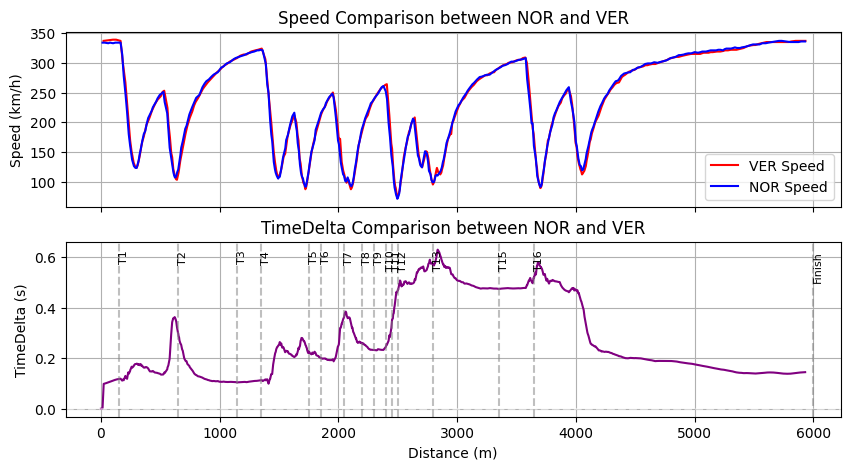

In [103]:
#Lap Time Difference
corners_baku = {
    "T1": 150,
    "T2": 650,
    "T3": 1150,
    "T4": 1350,
    "T5": 1750,
    "T6": 1850,
    "T7": 2050,
    "T8": 2200,
    "T9": 2300,
    "T10": 2400,
    "T11": 2450,
    "T12": 2500,
    "T13": 2800,
    "T15": 3350,
    "T16": 3650,
    "Finish": 6000
}
import numpy as np

v_time = (v_telemetry['SessionTime'] - v_telemetry['SessionTime'].iloc[0]).dt.total_seconds()

n_time = (n_telemetry['SessionTime'] - n_telemetry['SessionTime'].iloc[0]).dt.total_seconds()

distance = np.linspace(0, min(v_telemetry['Distance'].max(), n_telemetry['Distance'].max()), 5000)

v_interp = np.interp(distance, v_telemetry['Distance'], v_time)

n_interp = np.interp(distance, n_telemetry['Distance'], n_time)

delta = n_interp - v_interp

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,5), sharex=True)


ax1.plot(v_telemetry['Distance'], v_telemetry['Speed'], color='red', label='VER Speed')
ax1.plot(n_telemetry['Distance'], n_telemetry['Speed'], color='blue', label='NOR Speed')
ax1.set_ylabel('Speed (km/h)')
ax1.set_title('Speed Comparison between NOR and VER')
ax1.legend()
ax1.grid(True)



ax2.plot(distance, delta, color='purple')
ax2.axhline(0, color='white', linestyle='--', alpha=0.5)
ax2.set_xlabel('Distance (m)')
ax2.set_ylabel('TimeDelta (s)')
ax2.set_title('TimeDelta Comparison between NOR and VER')

for name, dist in corners_baku.items():
    plt.axvline(x=dist, color='gray', linestyle='--', alpha=0.5)
    plt.text(dist, plt.ylim()[1] * 0.95, name, rotation=90, verticalalignment='top', fontsize=8)

plt.grid(True)

plt.show()

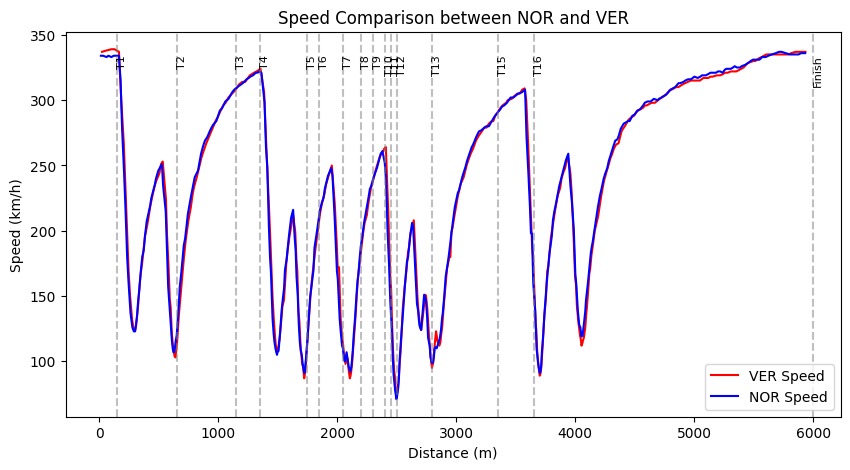

In [97]:
corners_baku = {
    "T1": 150,
    "T2": 650,
    "T3": 1150,
    "T4": 1350,
    "T5": 1750,
    "T6": 1850,
    "T7": 2050,
    "T8": 2200,
    "T9": 2300,
    "T10": 2400,
    "T11": 2450,
    "T12": 2500,
    "T13": 2800,
    "T15": 3350,
    "T16": 3650,
    "Finish": 6000
}

plt.figure(figsize=(10,5))
plt.plot(v_telemetry['Distance'], v_telemetry['Speed'], color='red', label='VER Speed')
plt.plot(n_telemetry['Distance'], n_telemetry['Speed'], color='blue', label='NOR Speed')
plt.xlabel('Distance (m)')
plt.ylabel('Speed (km/h)')
plt.title('Speed Comparison between NOR and VER')

for name, dist in corners_baku.items():
    plt.axvline(x=dist, color='gray', linestyle='--', alpha=0.5)
    plt.text(dist, plt.ylim()[1] * 0.95, name, rotation=90, verticalalignment='top', fontsize=8)

plt.legend()
plt.show()

In [5]:
cd C:\Users\rishi\PycharmProjects\JupyterProject\sample.ipynb

[WinError 267] The directory name is invalid: 'C:\\Users\\rishi\\PycharmProjects\\JupyterProject\\sample.ipynb'
C:\Users\rishi\PycharmProjects\JupyterProject
